# Tweet Stock Sentiment Project 4 (NP)

Christian Branton

In [329]:
import json
import pandas as pd
import numpy as np
import re
import datetime

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

## Load API data into dataframe
We load the data acquired from the twitter API into a dataframe so we can clean it and manipulate it easier

In [3]:
tweets_data_path = 'twitter_data_np.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
print(len(tweets_data))

8299


In [4]:
tweets = pd.DataFrame(tweets_data)
print(tweets.columns)


Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'extended_tweet', 'favorite_count',
       'favorited', 'filter_level', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user',
       'withheld_in_countries'],
      dtype='object')


In [5]:
tweets.head(3)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Tue May 14 13:12:15 +0000 2019,"[13, 60]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Kapt_Kopter Chevron was always the really ton...,1557839535123,False,"{'id': 1039991537214676993, 'id_str': '1039991...",NaN
1,None,None,Tue May 14 13:12:20 +0000 2019,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,low,...,0,0,False,{'created_at': 'Tue May 14 13:09:31 +0000 2019...,"<a href=""http://twitter.com/download/iphone"" r...",RT @FT_PWM: BlackRock bonds boss warns markets...,1557839540322,False,"{'id': 138039861, 'id_str': '138039861', 'name...",NaN
2,None,None,Tue May 14 13:12:24 +0000 2019,"[0, 140]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,{'full_text': 'Exxon Research circa 1982--spot...,0,False,low,...,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Exxon Research circa 1982--spot on with predic...,1557839544058,True,"{'id': 734755845808984068, 'id_str': '73475584...",NaN


## Drop unnecessary features and keep only English Tweets
We only keep Tweets in English and drop many of the unecessary JSON features that are added in as features while making sure to keep important features such as extended, retweeted, truncated, etc.

In [6]:
tweets = tweets.drop(['contributors','coordinates','display_text_range','extended_entities','timestamp_ms',
                  'withheld_in_countries','id','id_str','in_reply_to_screen_name',
                 'quoted_status_id_str','quoted_status_permalink', 'in_reply_to_status_id',
                  'in_reply_to_status_id_str','in_reply_to_user_id', 'in_reply_to_user_id_str',
                 'quoted_status_id','geo'], axis=1)

In [7]:
tweets.head(1)

,created_at,entities,extended_tweet,favorite_count,favorited,filter_level,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,reply_count,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,Tue May 14 13:12:15 +0000 2019,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,0,False,low,False,en,None,NaN,0,NaN,0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Kapt_Kopter Chevron was always the really ton...,False,"{'id': 1039991537214676993, 'id_str': '1039991..."


In [8]:
print(tweets.filter_level.unique())
print(tweets.is_quote_status.unique())
print(tweets.favorited.unique())
print(tweets.retweeted.unique())
print(tweets.truncated.unique())
print(tweets.favorite_count.unique())
print(tweets.reply_count.unique())
print(tweets.retweet_count.unique())
print(tweets.quote_count.unique())
print(tweets.possibly_sensitive.unique())

['low']
[False  True]
[False]
[False]
[False  True]
[0]
[0]
[0]
[0]
[nan False True]


In [9]:
tweets = tweets.drop(['filter_level','favorited','retweeted','favorite_count','reply_count','retweet_count','quote_count',
                                    'possibly_sensitive'], axis=1)

In [10]:
tweets_eng = tweets[tweets.lang == 'en'].reset_index()
tweets_eng.drop('index', axis=1, inplace=True)

## Find and append the full length and correct tweets
We use the features that hold the full length tweet or retweeted comments and dig within the dictionaries to find the correct tweet.

In [11]:
tweets_eng['new_text'] = [t if pd.isna(ex) else ex['full_text'] for (ex, t) in zip(tweets_eng.extended_tweet, tweets_eng.text)]
#df['new_text2'] = [t if pd.isna(ex) else if ex['quoted_status']['extended_tweet']['full_text'] for (ex, t) in zip(df.retweeted_status, df.text)]

newlist= []

for i in list(zip(tweets_eng.retweeted_status, tweets_eng.text)):   
    ex = i[0]
    t = i[1]
    if pd.isna(ex):
        newlist.append(t)
    elif "extended_tweet" in ex:
        newlist.append(ex['extended_tweet']['full_text'])
    elif "quoted_status" in ex:
        if "extended_tweet" in ex['quoted_status']:
            newlist.append(ex['quoted_status']['extended_tweet']['full_text'])
        else:
            newlist.append(ex['quoted_status']['text'])
        
    elif "text" in ex:
        newlist.append(ex['text'])
    else:
        print("i have more work to do")

In [12]:
tweets_eng["new_text2"] = newlist

In [13]:
print(tweets_eng.new_text2.isna().sum())
tweets_eng.head(1)

0


,created_at,entities,extended_tweet,is_quote_status,lang,place,quoted_status,retweeted_status,source,text,truncated,user,new_text,new_text2
0,Tue May 14 13:12:15 +0000 2019,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,en,None,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Kapt_Kopter Chevron was always the really ton...,False,"{'id': 1039991537214676993, 'id_str': '1039991...",@Kapt_Kopter Chevron was always the really ton...,@Kapt_Kopter Chevron was always the really ton...


## Sentiment Analysis of all tweets
We use textblob and vader and find the sentiment of all the remaining tweets

In [14]:
# Each word in the lexicon has scores for:
# 1)     polarity: negative vs. positive    (-1.0 => +1.0)
# 2) subjectivity: objective vs. subjective (+0.0 => +1.0)
# 3)    intensity: modifies next word?      (x0.5 => x2.0)

def sentiment(num):
    print(tweets_eng.new_text2.iloc[num])
    analysis = TextBlob((tweets_eng.new_text2.iloc[num]))
    print('TextBlog:',analysis.sentiment)
    #print(df.new_text.iloc[num])    
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores((tweets_eng.new_text2.iloc[num]))
    score = score['compound']
    print('Vader:',str(score))
    return
sentiment(2)
#print(df.iloc[9])
#def sent(column)
#    df['vader_sentiment'] = str(score)[-7]

Exxon Research circa 1982--spot on with prediction of 415 ppm CO2 by 2019. This science-suppressing company made bi… https://t.co/w9jzmTVhoc
TextBlog: Sentiment(polarity=0.0, subjectivity=0.0)
Vader: 0.0


In [15]:
analyser = SentimentIntensityAnalyzer()
#score = analyser.polarity_scores((tweets_eng.new_text2.iloc[num]))
#score = score['compound']
tweets_eng['vader_sentiment'] = tweets_eng.new_text2.apply(lambda x: (analyser.polarity_scores(x))['compound'])

## Topic Modelling and Analysis
We use the stopwords in our stopwords folder for our stopwords list and use NMF and PCA with count vectorizor and tf-idf for topic modelling.

In [188]:
tweets_eng['datetime'] =  pd.to_datetime(tweets_eng['created_at'], utc=True)

In [189]:
com_scw = pd.read_csv('stopwords/smart-common-words.txt',header=None)
com_scw = com_scw.values.tolist()[0]
com_tsw = pd.read_csv('stopwords/twitter-stopwords - TA.txt',header=None)
com_tsw = com_tsw.values.tolist()[0]
com_sw = pd.read_csv('stopwords/stopWords.txt',header=None)
com_sw = com_sw.values.tolist()[0]
com_msw = pd.read_csv('stopwords/morestopwords.txt',header=None)
com_msw = com_msw.values.tolist()[0]
com_cew = pd.read_csv('stopwords/common-english-words.txt',header=None)
com_cew = com_cew.values.tolist()[0]
com_cev = pd.read_csv('stopwords/common-english-verbs.txt',header=None)
com_cev = com_cev.values.tolist()[0]
com_cepc = pd.read_csv('stopwords/common-english-prep-conj.txt',header=None)
com_cepc = com_cepc.values.tolist()[0]
com_cea = pd.read_csv('stopwords/common-english-adverbs.txt',header=None)
com_cea = com_cea.values.tolist()[0]
com_cead = pd.read_csv('stopwords/common-english-adjectives.txt',header=None)
com_cead = com_cead.values.tolist()[0]

In [190]:
new_com = com_scw+com_tsw
new_com2 = new_com+com_sw+com_msw
new_com3 = new_com2+com_cew+com_cev+com_cea+com_cead+com_cepc

In [191]:
corpus = tweets_eng[['new_text3']]
corpus = corpus.values.tolist()
corpus = [item for sublist in corpus for item in sublist]

In [321]:
corpusex = exxondf[['new_text3']]
corpusex = corpusex.values.tolist()
corpusex = [item for sublist in corpusex for item in sublist]

In [322]:
vectorizer = CountVectorizer(stop_words=new_com3,
                            min_df=.0009,
                            #max_df=.3,
                            max_features=500,
                            lowercase=True,
                            token_pattern=r'\b[^\d\W]+\b')
bag_of_words = vectorizer.fit_transform(corpusex)
feature_names = vectorizer.get_feature_names()
feature_names_np = np.array(vectorizer.get_feature_names())

nmf = NMF(1)
W = nmf.fit_transform(bag_of_words)
H = nmf.components_
doc_topic = nmf.fit_transform(bag_of_words)

for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in feature_names_np[topic.argsort()[-20:]]])))

Topic 1: degrees,fuel,fossil,exxonmobil,temperature,global,climate,freaky,horrifying,kylamandel,knew,thinkprogress,tsrandall,dioxide,emissions,levels,predictions,predicted,carbon,exxon


In [327]:
vectorizer = TfidfVectorizer(stop_words=new_com3,
                            min_df=.0009,
                            #max_df=.3,
                            max_features=500,
                            lowercase=True,
                            token_pattern=r'\b[^\d\W]+\b')


X = vectorizer.fit_transform(corpusex)
idx_to_word = np.array(vectorizer.get_feature_names())

# apply NMF
nmf = NMF(n_components=3, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_
 
# print the topics
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-15:]]])))

Topic 1: human,uncanny,comparison,evolved,ynpdeyrojo,milestone,ominous,exxon,carbon,predictions,tsrandall,levels,horrifying,freaky,dioxide
Topic 2: ongoing,niels,bohr,burning,fossil,fuel,temperature,global,exxon,carbon,climateprogress,kylamandel,thinkprogress,emissions,predicted
Topic 3: hell,exxonmobil,katearonoff,tmkrdavvgn,unconscionable,climate,sbmxgmhtsq,greed,problem,education,information,solve,exxonknew,exxon,knew


In [194]:
tweets_eng['new_text3'] = tweets_eng.new_text2.str.lower()

In [195]:
tweets_eng.head(1)

,created_at,entities,extended_tweet,is_quote_status,lang,place,quoted_status,retweeted_status,source,text,truncated,user,new_text,new_text2,vader_sentiment,datetime,new_text3
0,Tue May 14 13:12:15 +0000 2019,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,False,en,None,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",@Kapt_Kopter Chevron was always the really ton...,False,"{'id': 1039991537214676993, 'id_str': '1039991...",@Kapt_Kopter Chevron was always the really ton...,@Kapt_Kopter Chevron was always the really ton...,0.0,2019-05-14 13:12:15+00:00,@kapt_kopter chevron was always the really ton...


In [196]:
searchforcel = ['celgene']
searchforabb = ['abbvie']
searchforacc = ['accenture']
searchforbr = ['blackrock']
searchforgs = ['goldman']
searchforschl = ['schlumberger']
searchforex = ['exxon']
searchforchev = ['chevron']

In [197]:
celgenedf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforcel))].reset_index()
abbviedf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforabb))].reset_index()
accenturedf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforacc))].reset_index()
blackrockdf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforbr))].reset_index()
goldmandf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforgs))].reset_index()
schlumdf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforschl))].reset_index()
exxondf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforex))].reset_index()
chevrondf = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(searchforchev))].reset_index()

celgenedf2 = celgenedf.groupby(by=celgenedf.datetime)['vader_sentiment'].mean().reset_index()
abbviedf2 = abbviedf.groupby(by=abbviedf.datetime)['vader_sentiment'].mean().reset_index()
accenturedf2 = accenturedf.groupby(by=accenturedf.datetime)['vader_sentiment'].mean().reset_index()
blackrockdf2 = blackrockdf.groupby(by=blackrockdf.datetime)['vader_sentiment'].mean().reset_index()
goldmandf2 = goldmandf.groupby(by=goldmandf.datetime)['vader_sentiment'].mean().reset_index()
schlumdf2 = schlumdf.groupby(by=schlumdf.datetime)['vader_sentiment'].mean().reset_index()
exxondf2 = exxondf.groupby(by=exxondf.datetime)['vader_sentiment'].mean().reset_index()
chevrondf2 = chevrondf.groupby(by=chevrondf.datetime)['vader_sentiment'].mean().reset_index()

In [198]:
test = ["celgene",'abbvie','accenture','blackrock','goldman','schlumberger','exxon','chevron']
test = tweets_eng[tweets_eng['new_text3'].str.contains('|'.join(test)) == False]
test.new_text3.iloc[0]

'thoughts on commercial real-estate bubble in ireland was so insightful. in a past life headed leasing of (4 mio sq.… https://t.co/fwrxcfnhqo'

In [199]:
print(len(celgenedf.index))
print(len(abbviedf.index))
print(len(accenturedf.index))
print(len(blackrockdf.index))
print(len(goldmandf.index))
print(len(schlumdf.index))
print(len(exxondf.index))
print(len(chevrondf.index))
len(tweets_eng.index)

93
162
300
245
1100
48
2415
287


5368

## Sentiment Analysis and Engineering
We engineer our time period so it matches that of stock pricing and have it run by minute. We also engineer a shifting accumulated sentiment analysis over time so we can see whether the sentiment has been trending positive or negative within that day

In [200]:
df2 = tweets_eng.groupby(by=tweets_eng.datetime)['vader_sentiment'].mean().reset_index()

In [201]:
#tweets_eng.head()
#df3 = tweets_eng.groupby([pd.Grouper(key='datetime',freq='H'),tweets_eng.new_text3]).size().reset_index(name='count')

In [306]:
exxondf2.vader_sentiment.sort_values()

2177   -0.96890
935    -0.96160
905    -0.96160
2087   -0.94410
2209   -0.87790
2195   -0.87790
2247   -0.87790
2131   -0.87790
2245   -0.87790
2128   -0.87790
926    -0.86580
1544   -0.85910
405    -0.83600
1498   -0.81260
1793   -0.81260
582    -0.81260
384    -0.80740
880    -0.79640
2230   -0.79220
97     -0.79060
61     -0.78450
257    -0.78035
1458   -0.77830
1823   -0.77830
1964   -0.77830
714    -0.75060
1414   -0.73990
285    -0.73990
1179   -0.73990
1176   -0.73990
         ...   
537     0.64860
137     0.64860
423     0.65880
1892    0.65970
1647    0.65970
1027    0.66980
302     0.68080
1605    0.68080
1629    0.68080
893     0.68080
22      0.68080
906     0.69080
482     0.69080
340     0.69080
1050    0.69080
1620    0.69080
102     0.70960
928     0.71840
636     0.71840
473     0.72130
270     0.72690
998     0.75060
409     0.75790
702     0.76440
618     0.79640
2       0.80740
1712    0.82250
142     0.96900
1615    0.96900
115     0.96900
Name: vader_sentiment, L

In [320]:
exxondf.new_text3.iloc[142]
#exxondf.new_text3.iloc[905]

"going back through an internal report commissioned by exxon in 1982. i knew that #exxonknew about #climatechange. i just didn't fully appreciate how much they knew\n\n415 ppm co2 in 2019 - they totally called it. in 1982. and carried on anyway https://t.co/kcylxln4tj https://t.co/qp7njdaojf"

In [202]:
df2['shift_sent']=df2['vader_sentiment'].rolling(min_periods=1, window=11).sum()
exxondf2['shift_sent'] = exxondf2['vader_sentiment'].rolling(min_periods=1, window=11).sum()
celgenedf2['shift_sent'] = celgenedf2['vader_sentiment'].rolling(min_periods=1, window=11).sum()

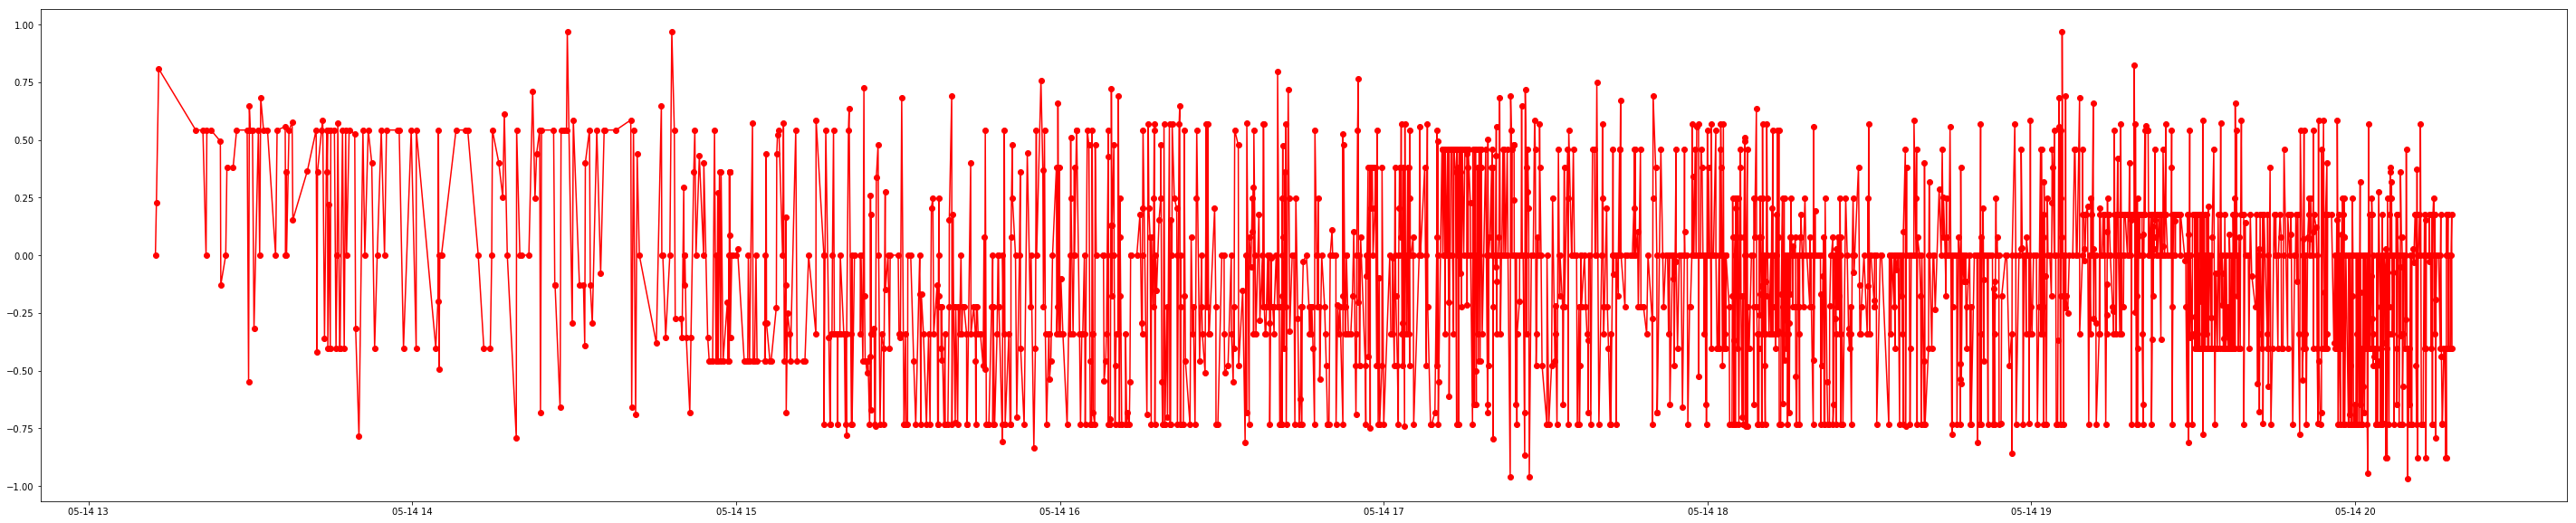

In [203]:
plt.figure(figsize=(50,10))
plt.plot_date(x=exxondf2.datetime, y=exxondf2.vader_sentiment,fmt="ro-",label="ROC_7")
plt.show();

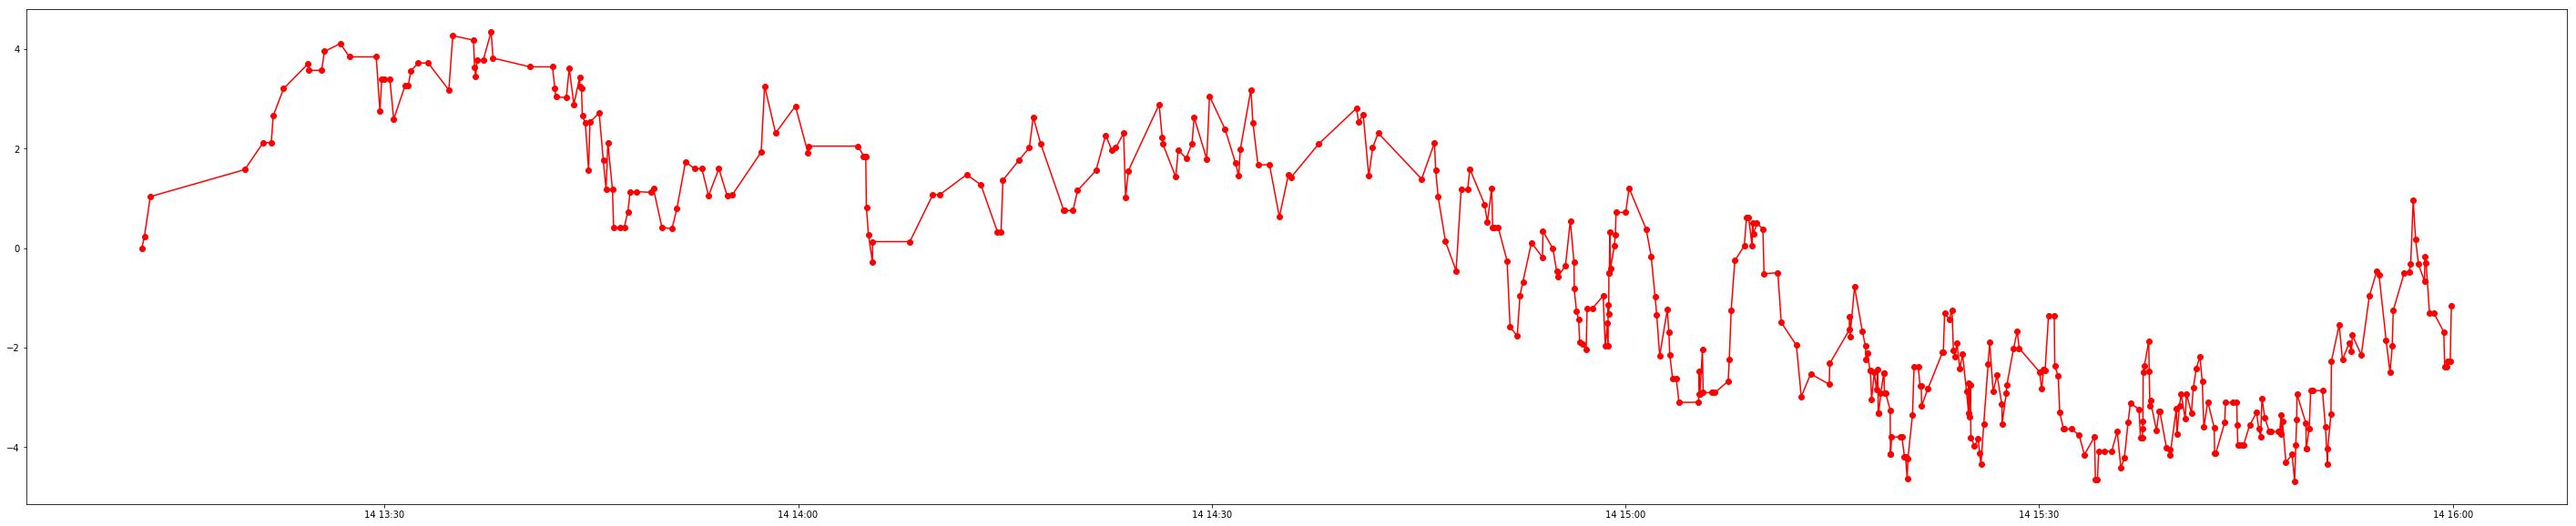

In [204]:
plt.figure(figsize=(50,10))
plt.plot_date(x=exxondfth.datetime, y=exxondfth.shift_sent,fmt="ro-",label="ROC_7")
plt.show();

In [205]:
print(df2.vader_sentiment.mean())
print('********************')
print(celgenedf2.vader_sentiment.mean())
print(abbviedf2.vader_sentiment.mean())
print(accenturedf2.vader_sentiment.mean())
print(blackrockdf2.vader_sentiment.mean())
print(goldmandf2.vader_sentiment.mean())
print(schlumdf2.vader_sentiment.mean())
print("***",exxondf2.vader_sentiment.mean())
print(chevrondf2.vader_sentiment.mean())

0.00398256437021535
********************
0.044164516129032265
0.009110759493670881
0.28371308724832206
0.13553884297520666
0.022875402726146167
0.2062083333333334
*** -0.09417835985853294
0.11511263157894741


In [433]:
exxondfth.head()
df3 = exxondfth.groupby(by=exxondfth.hour_minute)['vader_sentiment'].mean().reset_index()

In [434]:
df3

,hour_minute,vader_sentiment
0,13:12,0.113150
1,13:13,0.807400
2,13:19,0.542300
3,13:21,0.361533
4,13:22,0.542300
5,13:24,0.182950
6,13:25,0.190900
7,13:26,0.381800
8,13:27,0.542300
9,13:29,0.295825


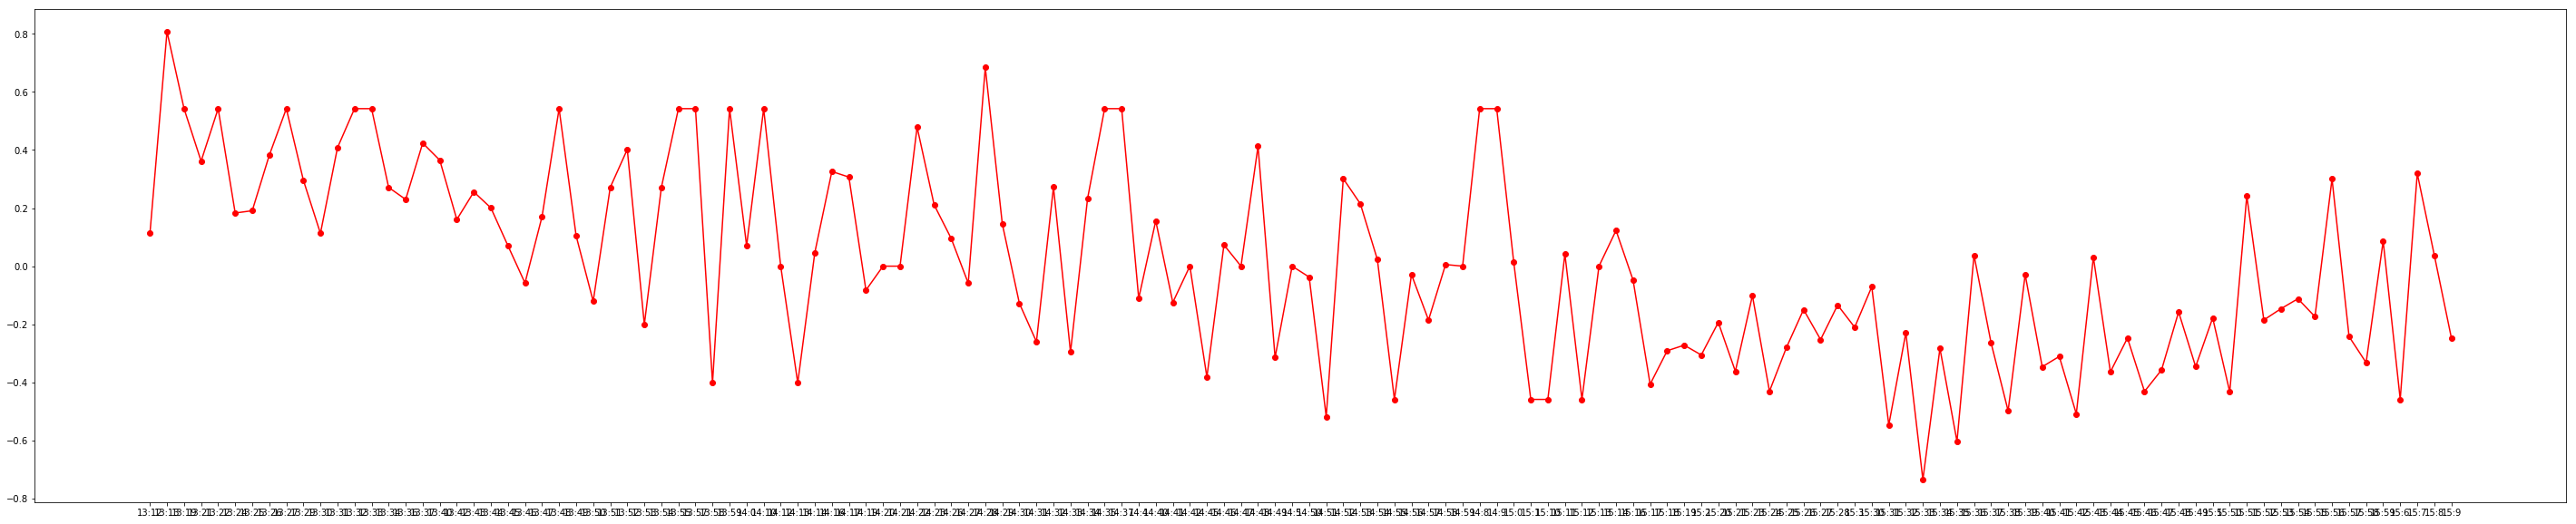

In [427]:
plt.figure(figsize=(50,10))
plt.plot_date(x=df3.hour_minute, y=df3.vader_sentiment,fmt="ro-",label="ROC_7")
plt.show();

In [263]:
exxondfth = exxondf2[exxondf2.datetime < '2019-05-14 16:00:00']

exxondfth['hour_minute'] = exxondfth['datetime'].apply(lambda x: "%d:%d" % (x.hour, x.minute))
exxoncount = exxondfth.groupby(['hour_minute']).count().reset_index()
exxoncount.head(1)

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hour_minute,datetime,vader_sentiment,shift_sent
0,13:12,2,2,2


In [73]:
date = ['May 14 13:12:24 2019','May 14 15:59:00 2019']
exxnstock = {'date':date, 'price':[76.33,75.84]}
exxnstock = pd.DataFrame(exxnstock)
exxnstock['datetime'] =  pd.to_datetime(exxnstock['date'])
exxnstock

,date,price,datetime
0,May 14 13:12:24 2019,76.33,2019-05-14 13:12:24
1,May 14 15:59:00 2019,75.84,2019-05-14 15:59:00


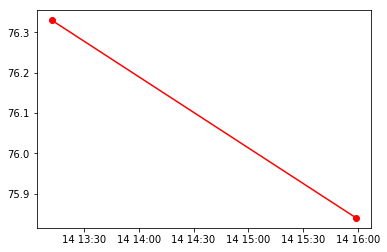

-0.09417835985853294


0.6460970464134963

In [74]:
plt.plot_date(x=exxnstock.datetime, y=exxnstock.price,fmt="ro-",label="ROC_7")

plt.show();
print(exxondf2.vader_sentiment.mean())
((exxnstock.price.max() / exxnstock.price.min()) - 1)*100

In [93]:
with open('exxon_stock_0514.txt') as json_file:  
    data = json.load(json_file)

In [128]:
stocks.head(1)

,average,changeOverTime,close,date,high,label,low,marketAverage,marketChangeOverTime,marketClose,...,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,minute,notional,numberOfTrades,open,volume,datetime
0,-1.0,NaN,NaN,20190514,-1.0,09:30 AM,-1.0,75.885,0.0,75.88,...,405377.99,29,76.13,5342,09:30,0.0,0,NaN,0,2019-05-14 09:30:00


In [125]:
stocks = pd.DataFrame(data)
stocks['datetime'] =  pd.to_datetime(stocks.date + stocks.minute, format='%Y%m%d%H:%M')

In [131]:
stocksfth = stocks[stocks.datetime >= '2019-05-14 13:12:24']

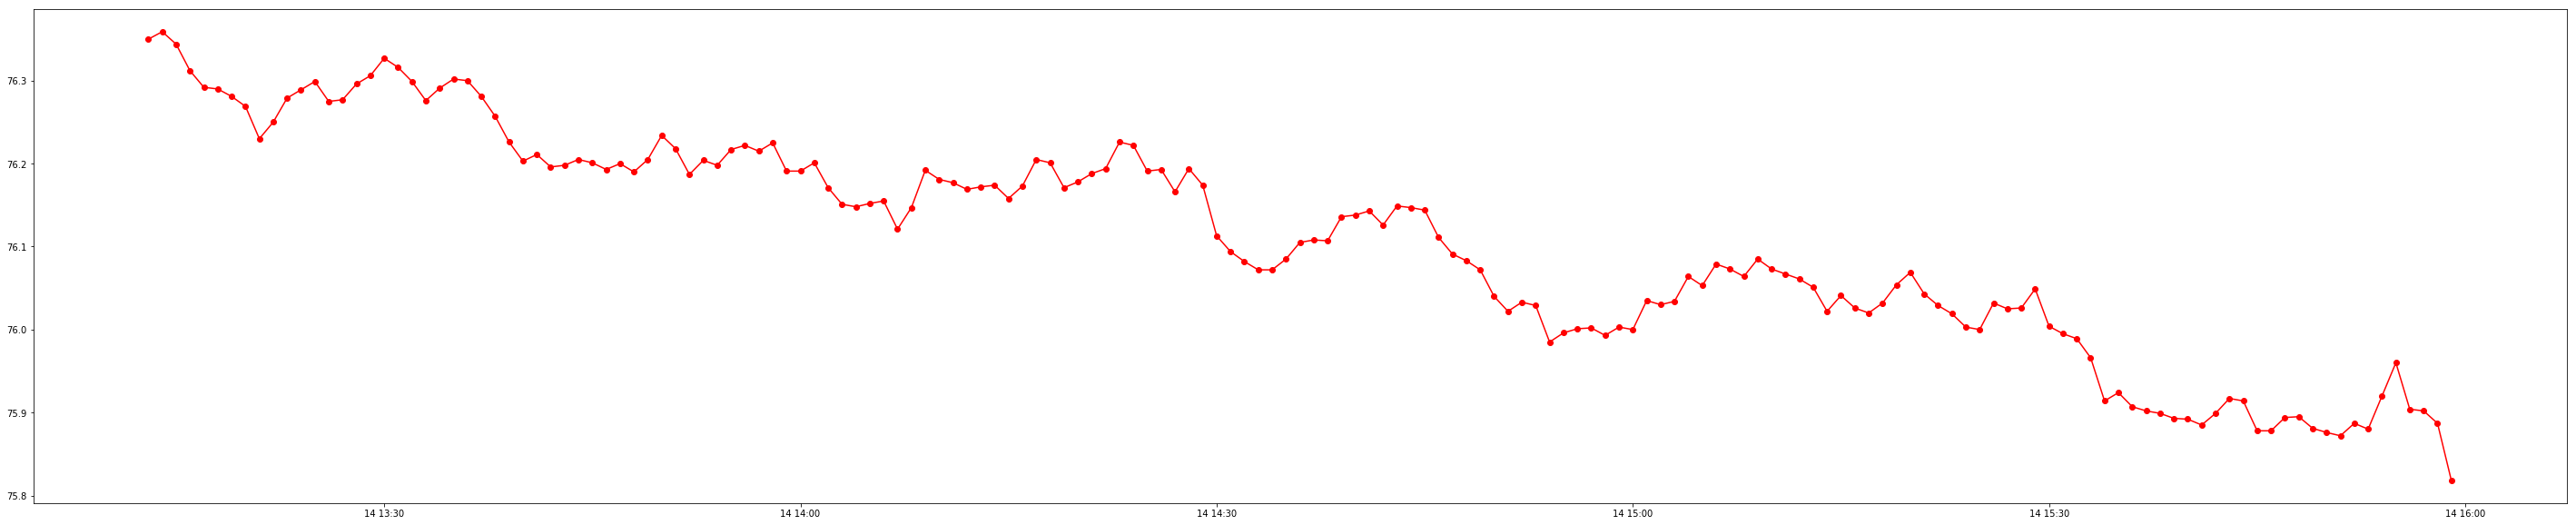

In [134]:
plt.figure(figsize=(50,10))
plt.plot_date(x=stocksfth.datetime, y=stocksfth.marketAverage,fmt="ro-",label="ROC_7")
plt.show();

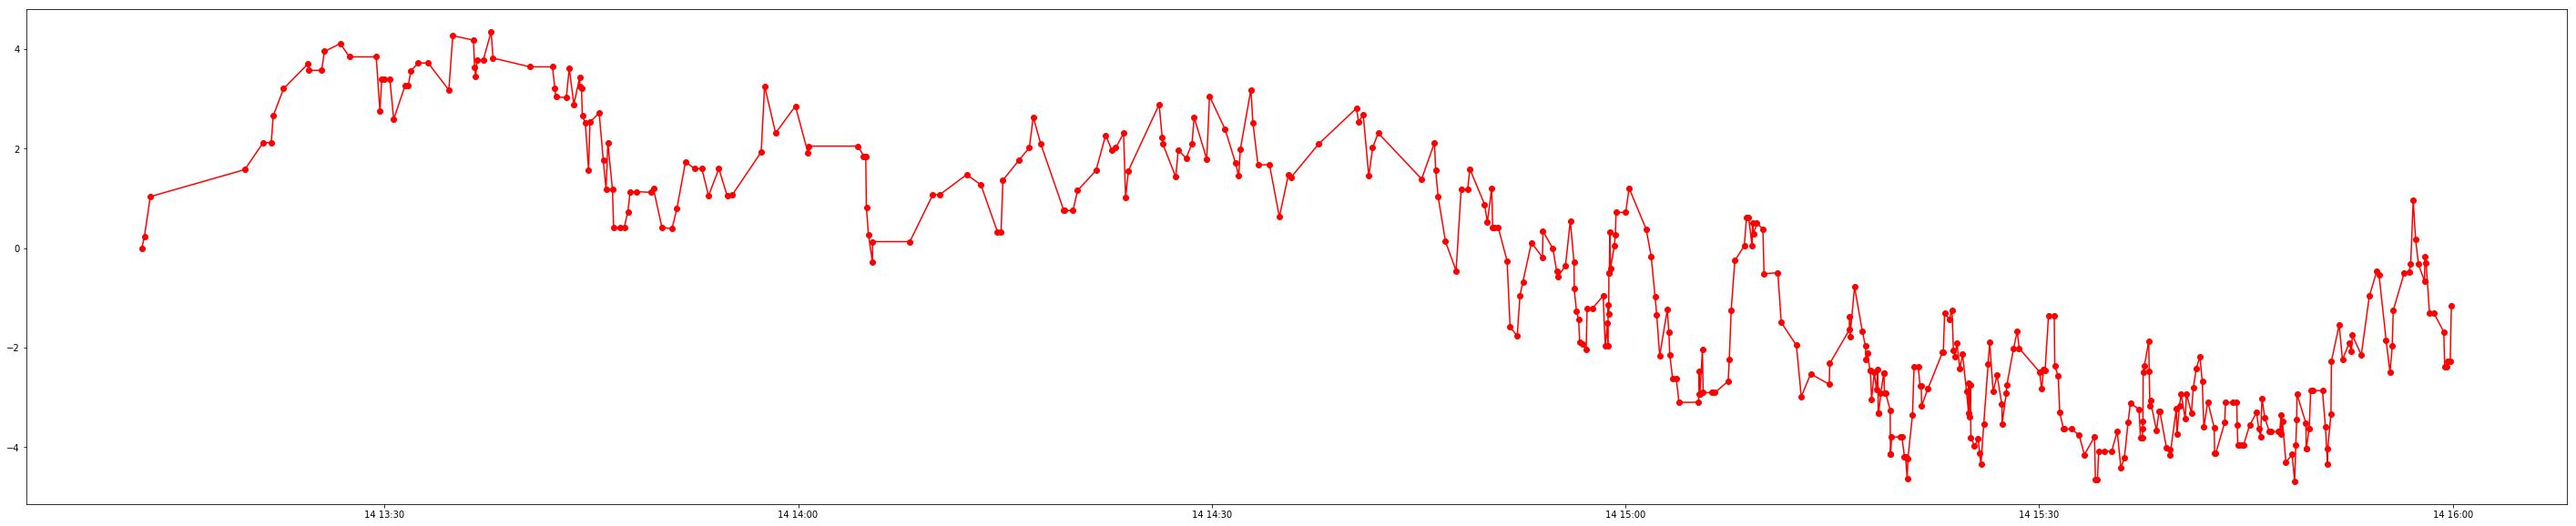

In [135]:
plt.figure(figsize=(50,10))
plt.plot_date(x=exxondfth.datetime, y=exxondfth.shift_sent,fmt="ro-",label="ROC_7")
plt.show();

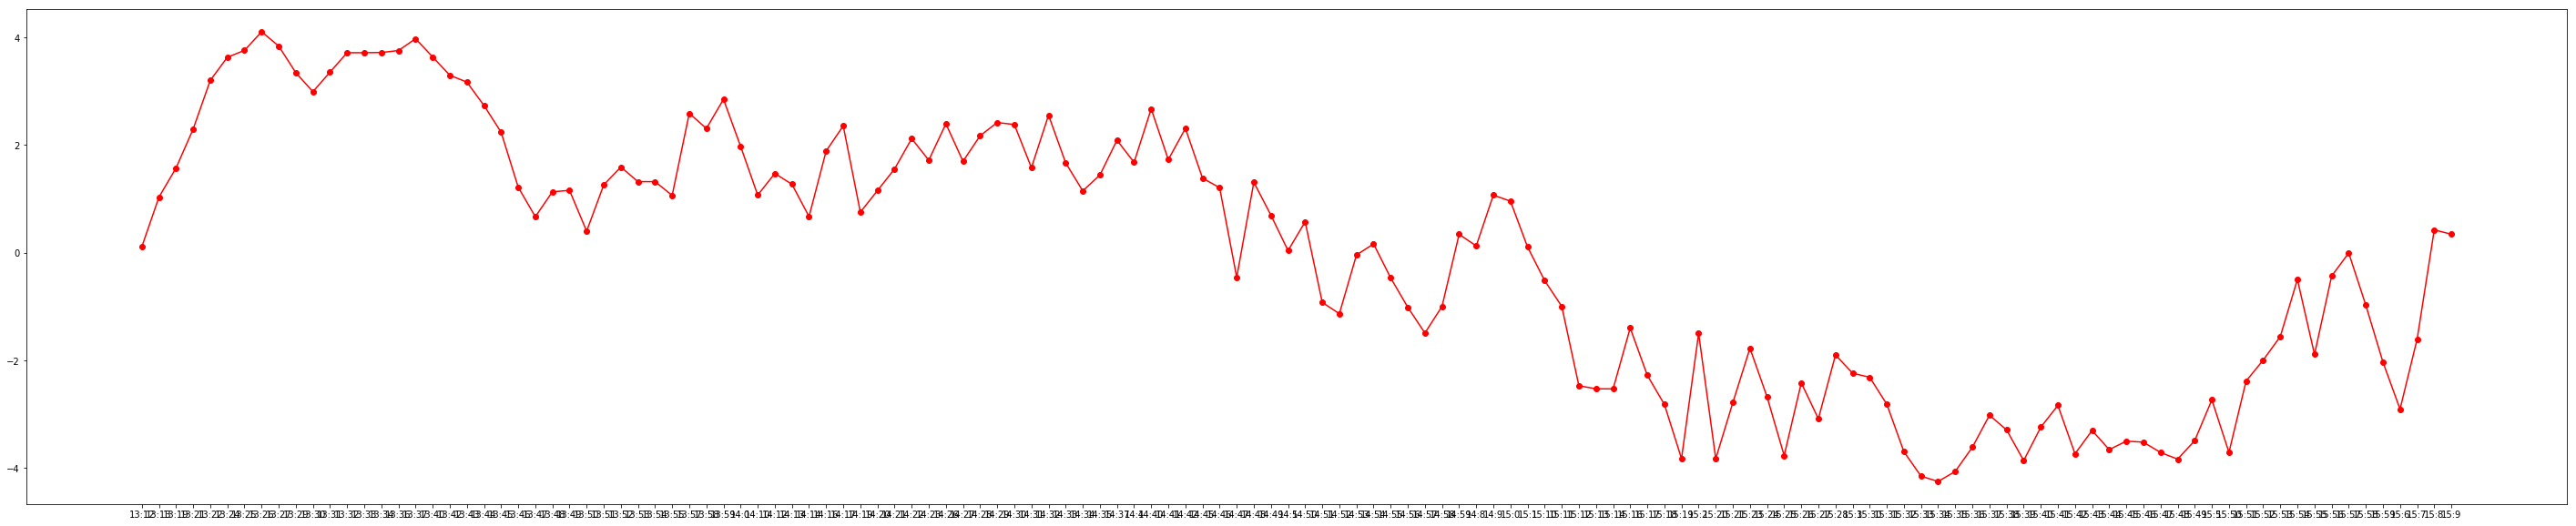

In [276]:
plt.figure(figsize=(50,10))
plt.plot_date(x=exxondfth2.hour_minute, y=exxondfth2.shift_sent,fmt="ro-",label="ROC_7")
plt.show();

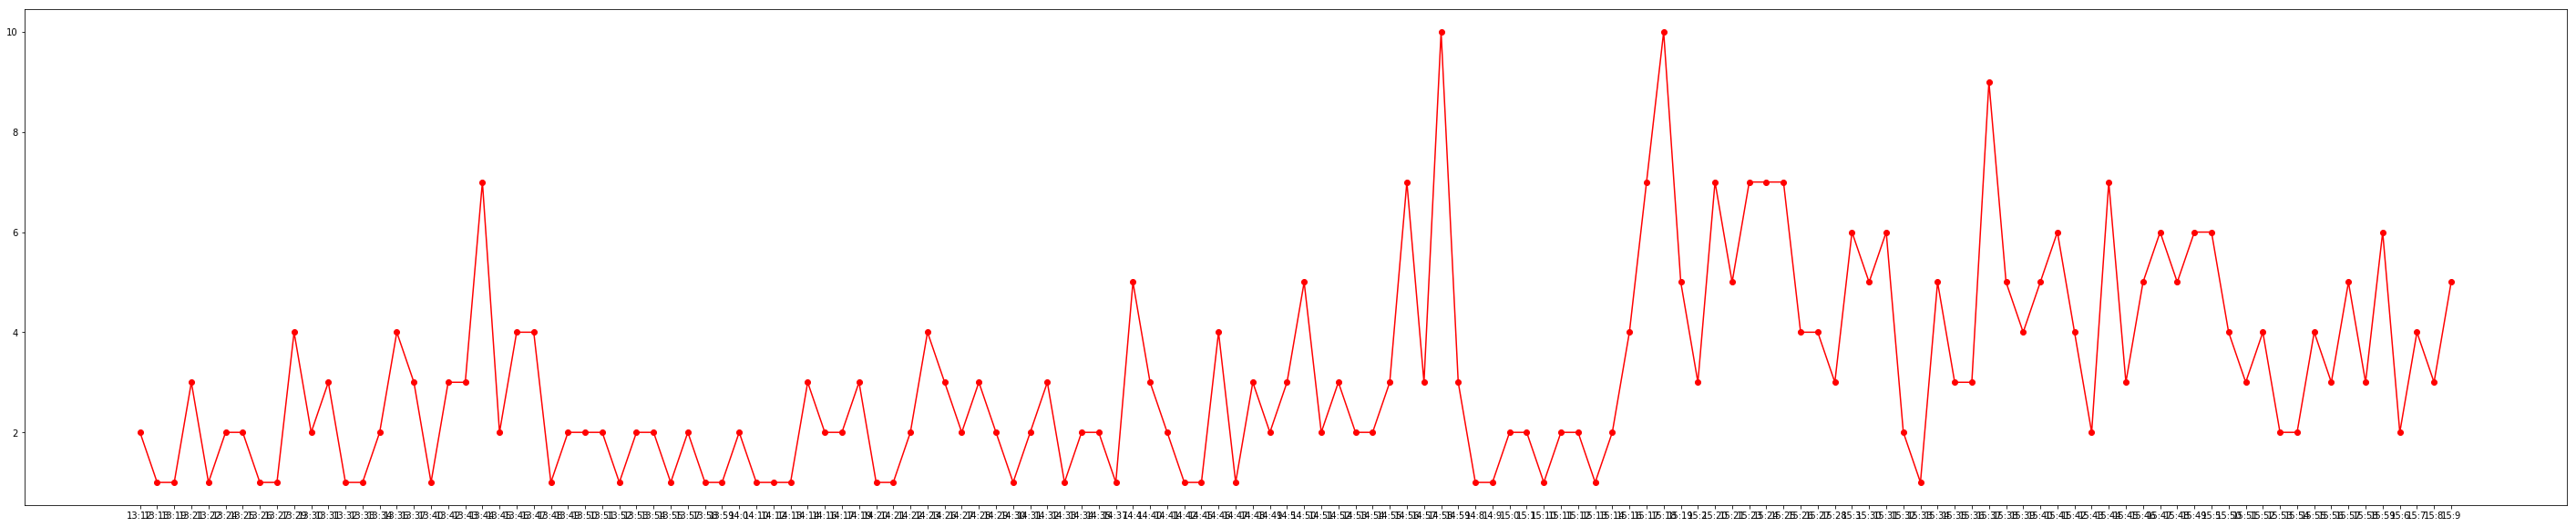

In [264]:
plt.figure(figsize=(50,10))
plt.plot_date(x=exxoncount.hour_minute, y=exxoncount.datetime,fmt="ro-",label="ROC_7")
plt.show();

In [275]:
exxondfth2 = exxondfth.groupby(by='hour_minute')['shift_sent'].mean().reset_index()

In [265]:
df2 = exxondfth.groupby(by=exxondfth.datetime)['vader_sentiment'].mean().reset_index()

In [291]:
tableau = exxondfth2.join(exxoncount.datetime)
tableau.rename(columns={'datetime':'count'}, inplace=True)
#exxondfth
#exxondfth2
#exxoncount
stocksfth['datetime2'] = stocksfth['datetime'].apply(lambda x: "%d:%d" % (x.hour, x.minute))
tableau.join(stocksfth.market)
stocksfth
#tableau

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [304]:
tableau.to_csv('tableau_tweet.csv')
stocksfth.to_csv('tableau_stock.csv')

In [428]:
df3.to_csv('tabluea_vader.csv')

In [305]:
stocksfth.head()

,average,changeOverTime,close,date,high,label,low,marketAverage,marketChangeOverTime,marketClose,...,marketNumberOfTrades,marketOpen,marketVolume,minute,notional,numberOfTrades,open,volume,datetime,datetime2
223,76.360,-77.360,76.365,20190514,76.365,1:13 PM,76.355,76.350,0.006128,76.365,...,129,76.340,23120,13:13,15272.000,2,76.355,200,2019-05-14 13:13:00,13:13
224,76.353,-77.353,76.345,20190514,76.360,1:14 PM,76.345,76.359,0.006246,76.350,...,100,76.370,19530,13:14,15270.500,2,76.360,200,2019-05-14 13:14:00,13:14
225,76.330,-77.330,76.320,20190514,76.340,1:15 PM,76.320,76.344,0.006049,76.330,...,82,76.340,11712,13:15,15266.000,2,76.340,200,2019-05-14 13:15:00,13:15
226,76.315,-77.315,76.315,20190514,76.315,1:16 PM,76.315,76.312,0.005627,76.300,...,36,76.320,8334,13:16,7631.500,1,76.315,100,2019-05-14 13:16:00,13:16
227,76.297,-77.297,76.290,20190514,76.305,1:17 PM,76.290,76.292,0.005363,76.285,...,37,76.305,7592,13:17,23270.515,4,76.305,305,2019-05-14 13:17:00,13:17


## Creating a Word Cloud of Exxon Topic Modelling

In [390]:
stopwords = (new_com3)
stopwords.remove(False)

In [409]:
#a = list(stopwords)
a = new_com3

In [410]:
b = [v for v in a if type(v)==str]

In [413]:
stopwords = set(b)

In [405]:
if type(a[0]) == str:
    print("t")

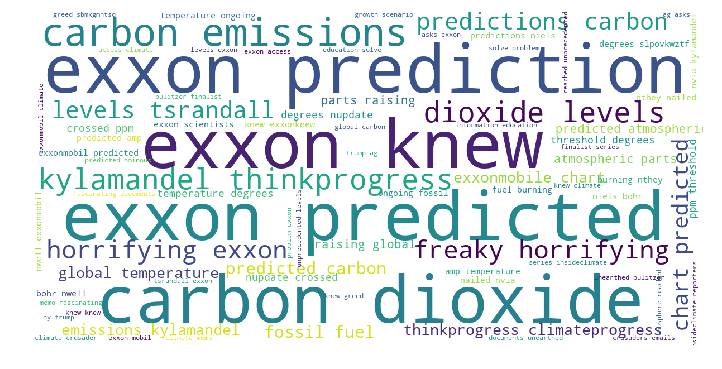

In [420]:

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        regexp=r'\b[^\d\W]+\b',
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    #fig.savefig('wordcloud.svg', format='svg', dpi=1200)
show_wordcloud(corpusex)
